In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import h5py
from load_data import voxelize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
from PIL import Image

def visualize_voxel(voxel_grid):
    """
    Visualizes a 3D binary voxel grid using matplotlib.

    Parameters:
    voxel_grid (numpy.ndarray): A 3D binary voxel grid where 1 indicates occupancy and 0 indicates empty.
    """

    # Get the coordinates of occupied voxels
    occupied_voxels = np.argwhere(voxel_grid == 1)

    # Create a 3D plot
    fig = plt.figure()
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Plot occupied voxels as scatter points
    ax.scatter(occupied_voxels[:, 0], occupied_voxels[:, 2], occupied_voxels[:, 1])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])

    # Set the limits for the axes
    ax.set_xlim([0, voxel_grid.shape[0]])
    ax.set_ylim([0, voxel_grid.shape[1]])
    ax.set_zlim([0, voxel_grid.shape[2]])


    
    ax.axis("off")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Move the buffer cursor to the beginning
    plt.close()
    # Convert the buffer into a Pillow Image
    img = Image.open(buf)
    return img

In [2]:
# load the preprocessed voxel data.
voxels = np.load("./data/hdf5_data/chair_voxels_train.npy")
# voxels = np.load("./generated_samples/chair_samples.npy")
print(voxels.shape)

(2658, 128, 128, 128)


128


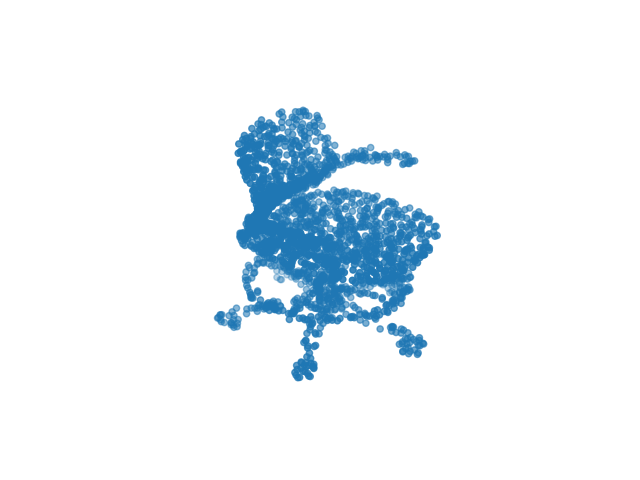

In [3]:
img = visualize_voxel(voxels[0])
display(img)